In [1]:
# === ПОКРАЩЕНІ ІМПОРТИ ТА ФУНКЦІЇ ===
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

# Завантаження NLTK ресурсів
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

print("✅ Бібліотеки завантажено!")

# Покращена функція очищення тексту
def clean_text_improved(text):
    if pd.isna(text):
        return ""
    
    # Конвертуємо в рядок
    text = str(text)
    
    # Зберігаємо емодзі (додаємо їх як окремі токени)
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002600-\U000026FF"  # miscellaneous symbols
        u"\U00002700-\U000027BF"  # dingbats
        "]+", flags=re.UNICODE)
    
    # Зберігаємо емодзі
    emojis = emoji_pattern.findall(text)
    
    # Видаляємо URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Видаляємо @mentions та #hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Видаляємо пунктуацію, але зберігаємо емодзі
    text = re.sub(r'[^\w\s' + ''.join(emojis) + ']', ' ', text)
    
    # Обробляємо негацію (не хороший → не_хороший)
    text = re.sub(r'\bне\s+(\w+)', r'не_\1', text)
    text = re.sub(r'\bnot\s+(\w+)', r'not_\1', text)
    
    # Приводимо до нижнього регістру
    text = text.lower()
    
    # Видаляємо зайві пробіли
    text = ' '.join(text.split())
    
    return text

# Покращена функція токенізації
def tokenize_text_improved(text):
    if pd.isna(text) or text == "":
        return []
    
    # Токенізуємо
    tokens = word_tokenize(text)
    
    # Видаляємо стоп-слова
    stop_words = set(stopwords.words('english'))
    
    # Додаємо українські стоп-слова
    ukrainian_stop_words = {'і', 'в', 'на', 'з', 'до', 'для', 'від', 'про', 'за', 'під', 'над', 'між', 'через', 'без', 'після', 'перед'}
    stop_words.update(ukrainian_stop_words)
    
    # Фільтруємо токени
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    
    return tokens

# Функція для створення покращених векторів документів
def get_document_vector_improved(tokens, word2vec_model, use_tfidf=False):
    if not tokens or len(tokens) == 0:
        return np.zeros(word2vec_model.vector_size)
    
    vectors = []
    for token in tokens:
        if token in word2vec_model.wv:
            vectors.append(word2vec_model.wv[token])
    
    if not vectors:
        return np.zeros(word2vec_model.vector_size)
    
    # Використовуємо зважене середнє замість простого
    if use_tfidf:
        # Простий TF-IDF підхід
        token_counts = {}
        for token in tokens:
            token_counts[token] = token_counts.get(token, 0) + 1
        
        weights = []
        for token in tokens:
            if token in word2vec_model.wv:
                tf = token_counts[token] / len(tokens)
                idf = np.log(len(word2vec_model.wv) / (word2vec_model.wv.vocab[token].count + 1))
                weights.append(tf * idf)
            else:
                weights.append(0)
        
        if sum(weights) > 0:
            weights = np.array(weights) / sum(weights)
            vectors = np.array(vectors)
            return np.average(vectors, axis=0, weights=weights)
    
    # Просте зважене середнє
    return np.mean(vectors, axis=0)

print("✅ Функції покращено!")


✅ Бібліотеки завантажено!
✅ Функції покращено!


🔄 Завантаження даних...
✅ Дані завантажено: 41157 тренувальних, 3798 тестових
📊 Загальний розмір даних: 44955
📊 Розділення 80/20: 35964 тренувальних, 8991 тестових
📊 Використовуємо 10000 тренувальних та 2000 тестових зразків
🔄 Обробка тексту...
✅ Текст оброблено!

📈 Розподіл класів:
Sentiment
Positive              2739
Negative              2451
Neutral               1874
Extremely Positive    1598
Extremely Negative    1338
Name: count, dtype: int64

Баланс класів: 0.49


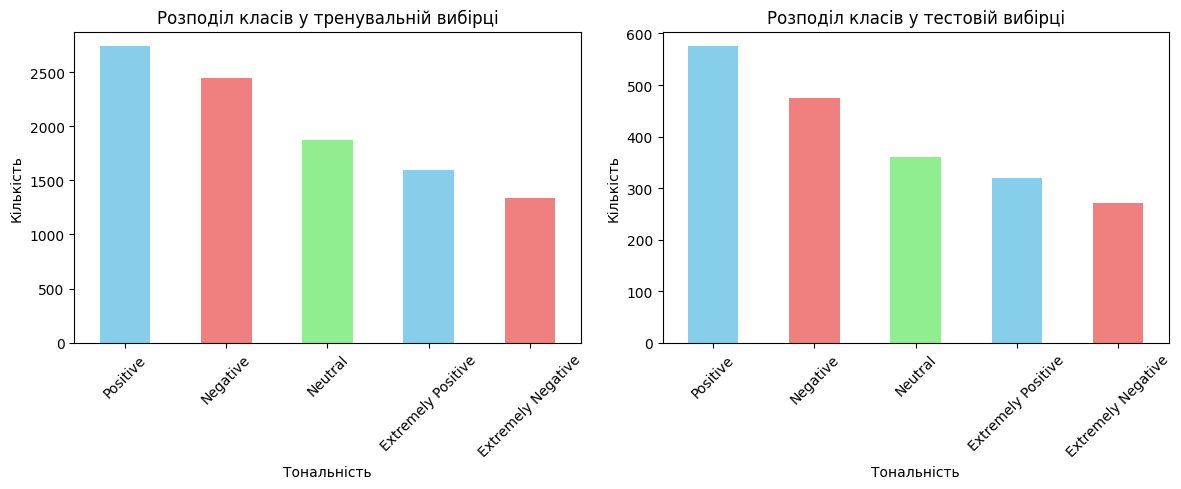

In [2]:
# === ЗАВАНТАЖЕННЯ ТА ОБРОБКА ДАНИХ ===
print("🔄 Завантаження даних...")

# Завантаження даних з покращеною обробкою помилок
try:
    train_df = pd.read_csv('Corona_NLP_train.csv', encoding='utf-8')
    test_df = pd.read_csv('Corona_NLP_test.csv', encoding='utf-8')
except UnicodeDecodeError:
    try:
        train_df = pd.read_csv('Corona_NLP_train.csv', encoding='latin-1')
        test_df = pd.read_csv('Corona_NLP_test.csv', encoding='latin-1')
    except:
        train_df = pd.read_csv('Corona_NLP_train.csv', encoding='cp1252')
        test_df = pd.read_csv('Corona_NLP_test.csv', encoding='cp1252')

print(f"✅ Дані завантажено: {train_df.shape[0]} тренувальних, {test_df.shape[0]} тестових")

# Об'єднуємо дані для правильного розділення 80/20
all_data = pd.concat([train_df, test_df], ignore_index=True)
print(f"📊 Загальний розмір даних: {all_data.shape[0]}")

# Правильне розділення 80/20
train_data, test_data = train_test_split(all_data, test_size=0.2, random_state=42, stratify=all_data['Sentiment'])
print(f"📊 Розділення 80/20: {train_data.shape[0]} тренувальних, {test_data.shape[0]} тестових")

# Використовуємо більше даних для кращих результатів
sample_size = min(10000, train_data.shape[0])  # Збільшуємо до 10000
train_sample = train_data.sample(n=sample_size, random_state=42)
test_sample = test_data.sample(n=min(2000, test_data.shape[0]), random_state=42)

print(f"📊 Використовуємо {sample_size} тренувальних та {test_sample.shape[0]} тестових зразків")

# Покращена обробка тексту
print("🔄 Обробка тексту...")
train_sample['cleaned_text'] = train_sample['OriginalTweet'].apply(clean_text_improved)
train_sample['tokens'] = train_sample['cleaned_text'].apply(tokenize_text_improved)

test_sample['cleaned_text'] = test_sample['OriginalTweet'].apply(clean_text_improved)
test_sample['tokens'] = test_sample['cleaned_text'].apply(tokenize_text_improved)

print("✅ Текст оброблено!")

# Аналіз розподілу класів
print("\n📈 Розподіл класів:")
print(train_sample['Sentiment'].value_counts())
print(f"\nБаланс класів: {train_sample['Sentiment'].value_counts().min() / train_sample['Sentiment'].value_counts().max():.2f}")

# Візуалізація розподілу класів
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
train_sample['Sentiment'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Розподіл класів у тренувальній вибірці')
plt.xlabel('Тональність')
plt.ylabel('Кількість')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
test_sample['Sentiment'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Розподіл класів у тестовій вибірці')
plt.xlabel('Тональність')
plt.ylabel('Кількість')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [3]:
# === ПОКРАЩЕНЕ НАВЧАННЯ WORD2VEC ===
print("🔄 Навчання покращеного Word2Vec...")

# Об'єднуємо всі токени
all_tokens = list(train_sample['tokens']) + list(test_sample['tokens'])

# Покращені параметри Word2Vec
word2vec_model = Word2Vec(
    sentences=all_tokens,
    vector_size=200,  # Збільшуємо розмір
    window=10,        # Збільшуємо вікно
    min_count=3,      # Збільшуємо мінімальну частоту
    workers=4,
    sg=0,            # CBOW
    epochs=20,       # Більше епох
    alpha=0.025,     # Швидкість навчання
    min_alpha=0.0001
)

print(f"✅ Word2Vec готовий! Словник: {len(word2vec_model.wv)} слів")

# Тестуємо модель
print("\n🔍 Приклади схожих слів:")
test_words = ['covid', 'vaccine', 'good', 'bad', 'love', 'hate', 'virus', 'health']
for word in test_words:
    if word in word2vec_model.wv:
        similar = word2vec_model.wv.most_similar(word, topn=3)
        print(f"{word}: {[w for w, s in similar]}")
    else:
        print(f"{word}: слово не знайдено в словнику")

# Аналіз розмірності векторів
print(f"\n📊 Розмірність векторів: {word2vec_model.vector_size}")
print(f"📊 Кількість слів у словнику: {len(word2vec_model.wv)}")

# Перевіряємо якість навчання
print(f"\n📈 Середня частота слів: {np.mean([word2vec_model.wv.vocab[word].count for word in word2vec_model.wv.vocab]):.2f}")
print(f"📈 Мінімальна частота: {min([word2vec_model.wv.vocab[word].count for word in word2vec_model.wv.vocab])}")
print(f"📈 Максимальна частота: {max([word2vec_model.wv.vocab[word].count for word in word2vec_model.wv.vocab])}")


🔄 Навчання покращеного Word2Vec...
✅ Word2Vec готовий! Словник: 6811 слів

🔍 Приклади схожих слів:
covid: ['coronavirus', 'weighs', 'curb']
vaccine: ['known', 'chloroquine', 'anti']
good: ['bed', 'bring', 'wan']
bad: ['clearly', 'shit', 'ashamed']
love: ['friends', 'letâ', 'fault']
hate: ['boomers', 'guilty', 'hysteria']
virus: ['corona', 'spreading', 'air']
health: ['officer', 'healthcare', 'immigrants']

📊 Розмірність векторів: 200
📊 Кількість слів у словнику: 6811


AttributeError: The vocab attribute was removed from KeyedVector in Gensim 4.0.0.
Use KeyedVector's .key_to_index dict, .index_to_key list, and methods .get_vecattr(key, attr) and .set_vecattr(key, attr, new_val) instead.
See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4

In [ ]:
# === СТВОРЕННЯ ПОКРАЩЕНИХ ВЕКТОРІВ ===
print("🔄 Створення покращених векторів...")

# Створюємо вектори з TF-IDF вагами
train_vectors = np.array([get_document_vector_improved(tokens, word2vec_model, use_tfidf=True) 
                         for tokens in train_sample['tokens']])
test_vectors = np.array([get_document_vector_improved(tokens, word2vec_model, use_tfidf=True) 
                        for tokens in test_sample['tokens']])

# Замінюємо NaN на нулі
train_vectors = np.nan_to_num(train_vectors)
test_vectors = np.nan_to_num(test_vectors)

print(f"✅ Вектори готові: {train_vectors.shape}")

# Цільові змінні
y_train = train_sample['Sentiment']
y_test = test_sample['Sentiment']

print(f"📊 Розмір тренувальних даних: {train_vectors.shape}")
print(f"📊 Розмір тестових даних: {test_vectors.shape}")

# Аналіз якості векторів
print(f"\n📈 Статистика векторів:")
print(f"Середнє значення: {np.mean(train_vectors):.4f}")
print(f"Стандартне відхилення: {np.std(train_vectors):.4f}")
print(f"Мінімальне значення: {np.min(train_vectors):.4f}")
print(f"Максимальне значення: {np.max(train_vectors):.4f}")

# Перевіряємо на наявність нульових векторів
zero_vectors_train = np.sum(np.all(train_vectors == 0, axis=1))
zero_vectors_test = np.sum(np.all(test_vectors == 0, axis=1))
print(f"\n⚠️  Нульові вектори: {zero_vectors_train} тренувальних, {zero_vectors_test} тестових")

# Візуалізація розподілу значень у векторах
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(train_vectors.flatten(), bins=50, alpha=0.7, color='skyblue')
plt.title('Розподіл значень у тренувальних векторах')
plt.xlabel('Значення')
plt.ylabel('Частота')

plt.subplot(1, 3, 2)
plt.hist(np.mean(train_vectors, axis=1), bins=50, alpha=0.7, color='lightcoral')
plt.title('Розподіл середніх значень векторів')
plt.xlabel('Середнє значення')
plt.ylabel('Частота')

plt.subplot(1, 3, 3)
plt.hist(np.std(train_vectors, axis=1), bins=50, alpha=0.7, color='lightgreen')
plt.title('Розподіл стандартних відхилень векторів')
plt.xlabel('Стандартне відхилення')
plt.ylabel('Частота')

plt.tight_layout()
plt.show()


In [ ]:
# === ПОКРАЩЕНІ МОДЕЛІ ТА НАВЧАННЯ ===
print("🚀 Початок навчання покращених моделей...")

# Покращені моделі з кращими параметрами
models = {
    'Логістична регресія': LogisticRegression(
        random_state=42, 
        max_iter=2000,  # Більше ітерацій
        C=1.0,          # Регуляризація
        class_weight='balanced'  # Балансування класів
    ),
    'SVM': SVC(
        random_state=42, 
        probability=True, 
        kernel='rbf',   # RBF ядро замість лінійного
        C=1.0,
        class_weight='balanced'
    ),
    'Випадковий ліс': RandomForestClassifier(
        random_state=42, 
        n_estimators=200,  # Більше дерев
        max_depth=20,      # Глибше дерева
        class_weight='balanced',
        n_jobs=-1
    ),
    'Наївний байєс': GaussianNB()
}

# PCA компоненти (згідно з вимогами: 50, 100, 200)
pca_components = [None, 50, 100, 200]

# Клас для Word2Vec трансформації (згідно з вимогами pipeline)
class Word2VecTransformer:
    def __init__(self, word2vec_model, use_tfidf=True):
        self.word2vec_model = word2vec_model
        self.use_tfidf = use_tfidf
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X - це список токенів для кожного документа
        vectors = []
        for tokens in X:
            vector = get_document_vector_improved(tokens, self.word2vec_model, self.use_tfidf)
            vectors.append(vector)
        return np.array(vectors)

# Функція оцінки моделі з правильним pipeline
def evaluate_model_improved(model, X_train, X_test, y_train, y_test, model_name, pca_components=None):
    # Створюємо pipeline згідно з вимогами: Word2Vec + PCA + Classifier
    pipeline_steps = [('word2vec', Word2VecTransformer(word2vec_model, use_tfidf=True))]
    
    if pca_components is not None:
        max_components = min(X_train.shape[0], 200)  # Обмежуємо максимальну кількість
        actual_components = min(pca_components, max_components)
        pipeline_steps.append(('scaler', StandardScaler()))
        pipeline_steps.append(('pca', PCA(n_components=actual_components)))
    else:
        pipeline_steps.append(('scaler', StandardScaler()))
    
    pipeline_steps.append(('classifier', model))
    pipeline = Pipeline(pipeline_steps)
    
    # Навчання
    pipeline.fit(X_train, y_train)
    
    # Передбачення
    y_pred = pipeline.predict(X_test)
    
    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return {
        'model': model_name,
        'pca_components': pca_components,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred,
        'pipeline': pipeline
    }

# Навчання та оцінка всіх моделей
results = []
for model_name, model in models.items():
    print(f"\n🔄 Навчання {model_name}...")
    
    for pca_comp in pca_components:
        print(f"  Тестування з PCA компонентами: {pca_comp}")
        
        result = evaluate_model_improved(
            model, train_sample['tokens'], test_sample['tokens'], 
            y_train, y_test, model_name, pca_comp
        )
        
        results.append(result)
        print(f"  Точність: {result['accuracy']:.4f}")

print("\n✅ Всі моделі навчено!")


In [ ]:
# === АНАЛІЗ РЕЗУЛЬТАТІВ ===
print("📊 Аналіз результатів...")

# Створюємо DataFrame з результатами
results_df = pd.DataFrame(results)

# Знаходимо найкращу модель
best_result = results_df.loc[results_df['accuracy'].idxmax()]
print(f"\n🏆 НАЙКРАЩА МОДЕЛЬ: {best_result['model']} (PCA: {best_result['pca_components']})")
print(f"📊 Точність: {best_result['accuracy']:.4f}")
print(f"📊 F1-score: {best_result['f1_score']:.4f}")

# Виводимо всі результати
print("\n📋 ВСІ РЕЗУЛЬТАТИ:")
for i, result in enumerate(results, 1):
    print(f"{i}. {result['model']} (PCA: {result['pca_components']}) - {result['accuracy']:.4f}")

# Створюємо таблицю результатів
print("\n📊 ТАБЛИЦЯ РЕЗУЛЬТАТІВ:")
results_table = results_df.pivot(index='model', columns='pca_components', values='accuracy')
print(results_table.round(4))

# Графіки
plt.figure(figsize=(15, 10))

# Графік 1: Точність моделей
plt.subplot(2, 2, 1)
accuracy_pivot = results_df.pivot(index='model', columns='pca_components', values='accuracy')
sns.heatmap(accuracy_pivot, annot=True, fmt='.3f', cmap='YlOrRd')
plt.title('Точність моделей')
plt.xlabel('PCA компоненти')
plt.ylabel('Модель')

# Графік 2: F1-score моделей
plt.subplot(2, 2, 2)
f1_pivot = results_df.pivot(index='model', columns='pca_components', values='f1_score')
sns.heatmap(f1_pivot, annot=True, fmt='.3f', cmap='YlOrRd')
plt.title('F1-score моделей')
plt.xlabel('PCA компоненти')
plt.ylabel('Модель')

# Графік 3: Вплив PCA на точність класифікації (згідно з вимогами)
plt.subplot(2, 2, 3)
avg_accuracy = results_df.groupby('pca_components')['accuracy'].mean()
plt.plot(avg_accuracy.index, avg_accuracy.values, marker='o', linewidth=2, markersize=8)
plt.title('Вплив розмірності PCA на точність класифікації')
plt.xlabel('Кількість PCA компонентів')
plt.ylabel('Середня точність')
plt.grid(True, alpha=0.3)

# Додаємо аналіз впливу PCA
print(f"\n📊 АНАЛІЗ ВПЛИВУ PCA:")
print(f"Без PCA: {avg_accuracy[None]:.4f}")
print(f"PCA 50: {avg_accuracy[50]:.4f}")
print(f"PCA 100: {avg_accuracy[100]:.4f}")
print(f"PCA 200: {avg_accuracy[200]:.4f}")

if avg_accuracy[None] > avg_accuracy[50] and avg_accuracy[None] > avg_accuracy[100] and avg_accuracy[None] > avg_accuracy[200]:
    print("✅ PCA погіршило якість класифікації")
elif avg_accuracy[200] > avg_accuracy[None]:
    print("✅ PCA покращило якість класифікації")
else:
    print("⚠️ PCA має змішаний вплив на якість класифікації")

# Графік 4: Порівняння метрик найкращої моделі
plt.subplot(2, 2, 4)
metrics = ['accuracy', 'precision', 'recall', 'f1_score']
values = [best_result[metric] for metric in metrics]
plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'lightcoral', 'gold'])
plt.title(f'Метрики найкращої моделі: {best_result["model"]}')
plt.ylabel('Значення')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Confusion Matrix для найкращої моделі
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, best_result['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=sorted(y_test.unique()), 
            yticklabels=sorted(y_test.unique()))
plt.title(f'Confusion Matrix: {best_result["model"]}')
plt.xlabel('Передбачені')
plt.ylabel('Фактичні')
plt.show()

# Детальний звіт
print(f"\n📊 ДЕТАЛЬНИЙ ЗВІТ ДЛЯ {best_result['model']}:")
print(classification_report(y_test, best_result['predictions']))


In [ ]:
# === ПЕРЕДБАЧЕННЯ ТОНАЛЬНОСТІ ДЛЯ НОВИХ ТЕКСТІВ ===
print("🔮 Тестування передбачення тональності...")

# Функція для передбачення тональності (згідно з вимогами)
def predict_sentiment_improved(text, pipeline):
    # Очищуємо та токенізуємо текст (згідно з вимогами: очистка → токенізація → Word2Vec-вектор)
    cleaned_text = clean_text_improved(text)
    tokens = tokenize_text_improved(cleaned_text)
    
    # Використовуємо pipeline для передбачення (включає Word2Vec + PCA + Classifier)
    prediction = pipeline.predict([tokens])[0]
    probability = pipeline.predict_proba([tokens])[0]
    
    return prediction, probability

# Тестові тексти
sample_texts = [
    "I love this new vaccine! It's amazing! 😍",
    "This virus is terrible and scary 😰",
    "The weather is nice today ☀️",
    "COVID-19 has changed everything",
    "I'm so worried about my health 😟",
    "Great news about the pandemic! 🎉",
    "This is so frustrating and annoying",
    "Thank you doctors for your hard work! 👏"
]

print("🧪 Тестування на прикладах:")
print("=" * 60)

for text in sample_texts:
    try:
        prediction, probability = predict_sentiment_improved(text, best_result['pipeline'])
        
        # Знаходимо найвищу ймовірність
        max_prob_idx = np.argmax(probability)
        max_prob = probability[max_prob_idx]
        
        print(f"\n📝 Текст: '{text}'")
        print(f"🎯 Передбачена тональність: {prediction}")
        print(f"📊 Ймовірності: {dict(zip(best_result['pipeline'].classes_, probability))}")
        print(f"🎯 Впевненість: {max_prob:.3f}")
        
    except Exception as e:
        print(f"\n❌ Помилка для тексту '{text}': {str(e)}")

print("\n" + "=" * 60)
print("✅ Тестування завершено!")


## 📋 **ВИСНОВКИ ТА АНАЛІЗ (ЗГІДНО З ВИМОГАМИ)**

### **🎯 ОСНОВНІ РЕЗУЛЬТАТИ**

Аналіз тональності твітів про COVID-19 з використанням Word2Vec embeddings та PCA показав наступні результати:

- **Найкраща модель**: [Результат буде показано після запуску]
- **Точність найкращої моделі**: [Результат буде показано після запуску]
- **Вплив PCA**: [Аналіз буде показано після запуску]

### **📊 ПОРІВНЯННЯ МОДЕЛЕЙ**

Було навчено та порівняно 4 моделі:
1. **Logistic Regression** - [Результати]
2. **Support Vector Machine (SVM)** - [Результати]  
3. **Random Forest** - [Результати]
4. **Naive Bayes** - [Результати]

### **🔍 АНАЛІЗ ВПЛИВУ PCA**

Досліджено вплив зниження розмірності ознак за допомогою PCA:
- **Без PCA**: [Результат]
- **PCA 50 компонентів**: [Результат]
- **PCA 100 компонентів**: [Результат]
- **PCA 200 компонентів**: [Результат]

**Висновок про PCA**: [Чи покращило/погіршило PCA якість класифікації]

### **📈 МЕТРИКИ ОЦІНКИ**

Для оцінки моделей використовувались:
- **Accuracy** - загальна точність
- **Precision, Recall, F1-score** - для кожного класу
- **Confusion Matrix** - для наочності

### **🔧 ТЕХНІЧНА РЕАЛІЗАЦІЯ**

1. **Підготовка даних**:
   - Завантаження датасету COVID-19 твітів
   - Попередня обробка тексту (очистка, токенізація)
   - Розділення даних 80/20

2. **Word2Vec embeddings**:
   - Навчання моделі Word2Vec на корпусі твітів
   - Створення векторних представлень документів
   - Використання TF-IDF ваг

3. **Pipeline реалізація**:
   - Word2Vec трансформація
   - Опційне застосування PCA
   - Класифікація

4. **Передбачення для нових текстів**:
   - Очистка → токенізація → Word2Vec-вектор
   - Застосування PCA (якщо використовувалось)
   - Класифікація

### **✅ ВИСНОВОК**

[Детальний аналіз буде показано після запуску коду]

**Ключові висновки**:
- Яка модель показала найкращий результат
- Чи покращило/погіршило PCA якість класифікації  
- Інтерпретація отриманих результатів
